In [84]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
from sklearn.datasets import make_regression
MAX_ITER = 100

# Convex Optimization - Homework 3

The goal is to : $\text{minimize } \frac{1}{2} || X w - y || _2 ^2 + \lambda || w || _2 ^2 $ (LASSO) 

We've seen in question 1 that the dual problem of LASSO is : $\text{minimize } \left[ v ^T Q v + p ^T v \right] \text{   subject to   } A v \preceq b$

## Question 2 : Implement the barrier method to solve QP.

#### 2.1 Write a function **$\text{Centering Step}(Q,p,A,b,t,v_0, \epsilon )$**

> This functions implements the **Newton method** to solve the *centering step* given the inputs $(Q, p, A, b)$, the *barrier method* parameter $t$ (see lectures), initial variable $v_0$ and a target precision $\epsilon$. The function outputs the sequence of variables iterates $(v_i)_{i=1,...,n_{\epsilon}}$, where nε is the number of iterations to obtain the ε precision. Use a backtracking line search with appropriate parameters.

In [85]:
def dual_objective(Q, p, v):
    """Return the objective value for the dual problem of Lasso.

    Args:
        - Q, p : parameters of QP
        - v : evaluation point

    Returns:
        Value of the objective function
    """
    return np.vdot(Q @ v + p, v)

def f_0_dual(Q, p, v):
    return v.T @ Q @ v + p.T @ v


def f_0_primal(X, Y, w, lamb):
    return 0.5 * np.linalg.norm(X @ w - Y) ** 2 + lamb * np.linalg.norm(w, 1)


def dual_to_primal(X, Y, v):
    """Compute the primal solution given the dual one
    """
    return np.linalg.inv(X.T @ X) @ X.T @ (v + Y)

def barrier_obj(Q, p, A, b, v, t):
    """Compute the value of the barrier objective function."""
    d = b - A @ v  # Compute the difference once for reuse
    # Check if the point is feasible
    if not (d > 0).all():
        raise ValueError('v is not feasible !')
    # Compute the value of the barrier objective
    val = t * (v.T @ Q @ v + p.T @ v) - np.sum(np.log(d))
    return val

def barrier_gradient(Q, p, A, b, v, t):
    """Compute the gradient of the barrier objective function."""
    d = b - A @ v  # Compute the difference once for reuse
    grad_f0 = 2 * Q @ v + p
    grad_phi = A.T @ (1 / d)
    grad = t * grad_f0 + grad_phi
    return grad

def barrier_hessian(Q, p, A, b, v, t):
    """Compute the hessian of the barrier objective function."""
    d = b - A @ v  # Compute the difference once for reuse
    hess_phi = A.T @ np.diag(1. / d ** 2) @ A
    hess = 2 * t * Q + hess_phi
    return hess

In [86]:
def backtrack_line_search(Q, p, A, b, t, v, delta, lambda_sq, alpha = 0.01, beta = 0.5):
    """
    Perform backtracking line search.

    Parameters:
    - Q : matrix Q in the quadratic term of the objective function
    - p : vector p in the linear term of the objective function
    - A : matrix A in the constraints
    - b : vector b in the constraints
    - t : current value of t (for barrier method)
    - v : current point
    - delta : descent direction (step to move along)
    - alpha : parameter for sufficient decrease condition
    - beta : parameter for step size reduction

    Returns:
    - optimal step size (rate)
    """
    step_size = 1.
    for _ in range(MAX_ITER):
        next_point_feasible = (b - A @ (v + step_size * delta) > 0).all()
        
        # Stopping criterion
        if not next_point_feasible:
            break
        if barrier_obj(Q, p, A, b, v + step_size * delta, t) > barrier_obj(Q, p, A, b, v, t) - alpha * step_size * lambda_sq:
            break

        step_size *= beta
        
    return step_size

In [87]:
def centering_step(Q, p, A, b, t, v0, eps):
    """
    This function performs the centering step of the barrier method

    Parameters 
    ----------
    Q : numpy array
        Quadratic term of the target function
    p : numpy array
        Linear term of the target function
    A : numpy array
        Matrix of the constraints
    b : numpy array
        Vector of the constraints
    v0 : numpy array
        Initial point
    t : float
        Parameter of the barrier method
    epsilon : float
        Precision of the centering step
    alpha : float
        Parameter of the backtracking line search algorithm
    beta : float
        Parameter of the backtracking line search algorithm
    
    Returns 
    -------
    v : numpy array
        Suit of point of the centering step
    n_iter : int
        number of iterations to obtain eps precision
    """

    V_center = [v0]
    n_iter = 0

    for _ in range(MAX_ITER):
        grad, hess = barrier_gradient(Q, p, A, b, V_center[-1], t) ,barrier_hessian(Q, p, A, b, V_center[-1], t)
        hess_inv = np.linalg.inv(hess)
      
        # Compute Newton step and decrement
        dv_n = -hess_inv @ grad
        lambda_sq = -np.vdot(dv_n, grad)
        
        # Stopping criterion
        if lambda_sq / 2. <= eps:
            break

        # Line search by backtracking
        step_size = backtrack_line_search(Q, p, A, b, t, V_center[-1], dv_n, lambda_sq)

        # Update
        V_center.append(V_center[-1] + step_size * dv_n)
        n_iter += 1
    
    return V_center, n_iter

#### 2.2 Write a function **$ \text{Barr Method}(Q, p, A, b, v_0, \epsilon )$**

> This functions implements the **barrier method** to solve QP using precedent function given the data inputs $(Q, p, A, b)$, a feasible point $v0 $, a precision criterion $\epsilon $. The function outputs the sequence of variables iterates $ (v_i) _{i = 1, ..., n_{\epsilon } } $, where $n_{\epsilon }$ is the number of iterations to obtain the $ \epsilon $ precision.

In [88]:
def Barrier_Method(Q, p, A, b, v0, eps, mu, alpha = 0.01, beta = 0.5, t = 1):
    """ 
    This function implements the barrier method
    
    Parameters
    ----------
    
    Q : numpy array
        Quadratic term of the target function
    p : numpy array
        Linear term of the target function
    A : numpy array
        Matrix of the constraints
    b : numpy array
        Vector of the constraints
    x0 : numpy array
        Initial point
    eps : float
        Precision of the barrier method
    mu : float
        Parameter of the barrier method
    alpha : float
        Parameter of the backtracking line search algorithm
    beta : float
        Parameter of the backtracking line search algorithm
    t : float   
        Parameter of the barrier method
    n_iters : int
        number of iterations to obtain eps precision for each newton step
    """
    m = len(b)
    V = [v0]
    n_iters = [0]

    for _ in range(MAX_ITER):
        # Centering step
        V_center, n_iter = centering_step(Q, p, A, b, t, V[-1], eps)

        # Stopping criterion
        if m / t <= eps:
            break
        
        # Updating
        t *= mu
        V.append(V_center[-1])
        n_iters.append(n_iters[-1] + n_iter)
    
    return V, n_iters


## Question 3: 

>Test your function on randomly generated matrices $X$ and observations $y$ with $ \lambda = 10 $. 

> Plot *precision criterion* and *gap* $ f( v_t)− f ^* $ in semilog scale (using the best value found for $f$ as a surrogate for $f ^* $). Repeat for different values of the barrier method parameter $ \mu = 2, 15, 50, 100, . . . $ and check the impact on $w$. 

> What would be an appropriate choice for $ \mu $ ?

In [89]:
def generate_data(n, d, noise=1.):
    """Generate random matrices X and vectors y to test the log-barrier method

    Parameters:
    ----------
        - n : number of samples
        - d : number of features
        - noise : add gaussian noise to Y
    Returns:
    ----------
        - X : (n, d) data matrix
        - Y : (n, ) objective vector
        - w : (d, ) true weights
    """
    X, Y, w = make_regression(
                            n_samples = n,
                            n_informative = d,
                            n_features = d,
                            noise = noise,
                            coef = True,
                            )
    return X, Y, w


def build_lasso_params(X, Y, lamb):
    """Build the parameters for the lasso problem
    
    Parameters:
    ----------
        - X : (n, d) data matrix
        - Y : (n, ) objective vector
        - lamb : regularization parameter
    
    Returns:
        - Q : (n, n) quadratic term
        - p : (n, ) linear term
        - A : (2d, n) matrix of constraints
        - b : (2d, ) vector of constraints
    """
    n, d = X.shape
    Q = np.eye(n) / 2.
    p = Y
    A = np.vstack([X.T, -X.T])
    b = lamb * np.ones(2 * d)
    return Q, p, A, b

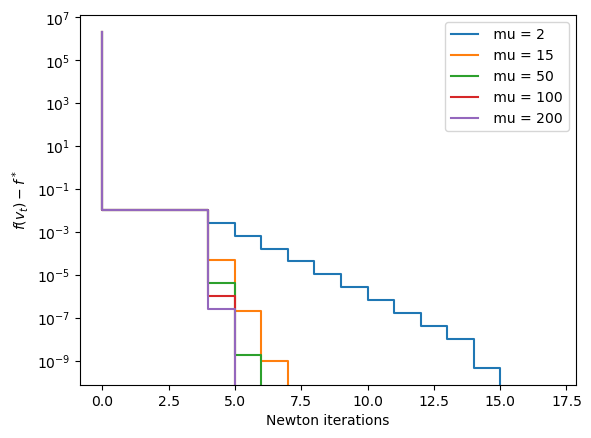

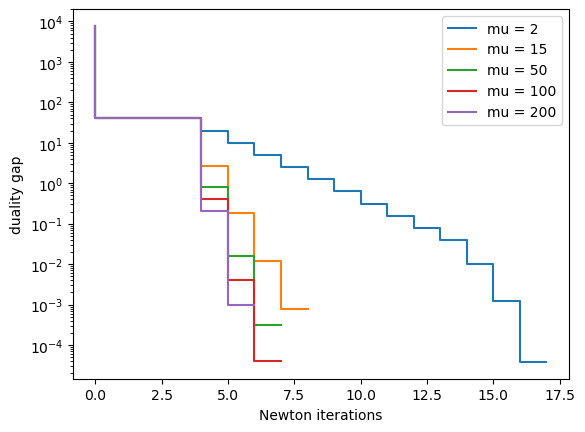

In [90]:
np.random.seed(2024)
n = 100
d = 20
lamb = 10
X, Y, w = generate_data(n, d)
Q, p, A, b = build_lasso_params(X, Y, lamb)

v0 = np.zeros(n)
eps = 10 ** -5
mus = [2, 15, 50, 100, 200]
plt.figure()

for mu in mus:
    V, n_iter = Barrier_Method(Q, p, A, b, v0, eps, mu)
    v_star = V[-1]
    values = [dual_objective(Q, p, v) - dual_objective(Q, p, v_star) for v in V]
    plt.step(n_iter, values, label =' mu = {}'.format(mu))

plt.semilogy()
plt.xlabel('Newton iterations')
plt.ylabel('$f(v_t) - f^*$')
plt.legend()
plt.legend(loc = 'upper right')
plt.show()

# Plot the dual gap evolution
for mu in mus:
    V, n_iter = Barrier_Method(Q, p, A, b, v0, eps, mu)
    W = [dual_to_primal(X, Y, v) for v in V]
    values = [f_0_primal(X, Y, W[i], lamb) + f_0_dual(Q, p, V[i]) for i in range(len(V))]
    plt.step(n_iter, values, label = 'mu = {}'.format(mu))

plt.semilogy()
plt.xlabel('Newton iterations')
plt.ylabel('duality gap')
plt.legend()
plt.legend(loc='upper right')
plt.show()
    

## Considerations 

- Choice of $\mu $: if $\mu $ is too small, then many outer iterations might be needed; if $\mu $ is too big, then Newton’s method (each centering step) might take many iterations to converge.

- Choice of $t_0 $: if $t_0 $ is too small, then many outer iterations might be needed; if $t_0 $ is too big, then the first Newton’s solve (first centering step) might require many iterations to compute $x_0$. 

But, the performance of the barrier method is often quite robust to the choice of $\mu $ and $t_0 $ in practice.